In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge

from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
)
from darts.metrics import mape
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.explainability import ShapExplainer

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Load dataset: Electricity Consumption Dataset

In [3]:
ts_raw = ElectricityConsumptionZurichDataset().load()

ts_raw[:5]

<TimeSeries (DataArray) (Timestamp: 5, component: 10, sample: 1)> Size: 400B
array([[[ 2.19759378e+04],
        [ 4.40624184e+04],
        [ 9.04700000e+01],
        [ 0.00000000e+00],
        [ 1.00000000e-02],
        [-2.48000000e+00],
        [ 3.53850000e+02],
        [ 6.10000000e-01],
        [ 6.00000000e-01],
        [ 9.82640000e+02]],

       [[ 2.21979830e+04],
        [ 4.34623818e+04],
        [ 9.02200000e+01],
        [ 0.00000000e+00],
        [ 1.00000000e-02],
        [-2.48000000e+00],
        [ 2.70760000e+02],
        [ 7.80000000e-01],
        [ 7.80000000e-01],
...
        [ 4.22154301e+04],
        [ 8.97000000e+01],
        [ 0.00000000e+00],
        [ 2.00000000e-02],
        [-2.46000000e+00],
        [ 1.04570000e+02],
        [ 1.14000000e+00],
        [ 1.13000000e+00],
        [ 9.82910000e+02]],

       [[ 2.19637068e+04],
        [ 4.19378650e+04],
        [ 8.94500000e+01],
        [ 0.00000000e+00],
        [ 2.00000000e-02],
        [-2.46000000e+00],
        [ 2.14800000e+01],
        [ 1.31000000e+00],
        [ 1.31000000e+00],
        [ 9.83000000e+02]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 40B 2015-01-01 ... 2015-01-01T01:00:00
  * component  (component) object 80B 'Value_NE5' 'Value_NE7' ... 'p [hPa]'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 1.0, 'Covariates of both train/val set')

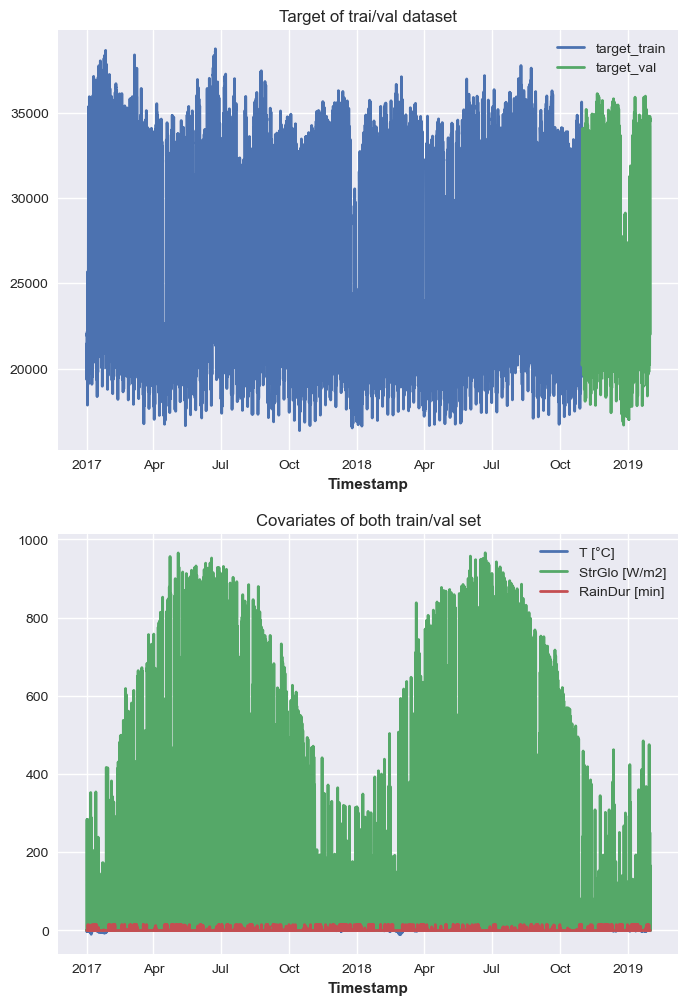

In [4]:
# extract values recorded between 2017 and 2019
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2019-01-31")
ts = ts_raw[start_date:end_date]

# resample to hourly frequency
ts = ts.resample(freq='h')

# extract temperature, solar irradiation and rain duration
cov_names = ['T [°C]', 'StrGlo [W/m2]', 'RainDur [min]']
ts_cov = ts[cov_names]

# extract households energy consumption
tgt_name = 'Value_NE5'
ts_energy = ts[tgt_name]

# create train and validation splits for target
validation_cutoff = pd.Timestamp("2018-10-31")
ts_energy_train, ts_energy_val = ts_energy.split_after(validation_cutoff)

# quick visualization
fig = plt.figure(figsize=(8, 12))

ax = fig.add_subplot(2, 1, 1)
ts_energy_train.plot(ax=ax, label='target_train')
ts_energy_val.plot(ax=ax, label='target_val')
ax.set_title('Target of trai/val dataset')

ax = fig.add_subplot(2, 1, 2)
ts_cov.plot(ax=ax)
ax.set_title('Covariates of both train/val set')

## Model experiments

### Covariates-only regression model

In extreme case which there is only past covariates available up to the cutoff date, what will the model behave ?

In [19]:
# create train and validation splits for target
ts_cov_train, ts_cov_val = ts_cov.split_after(validation_cutoff)
# ts_cov_train = None

output_chunk_length = 3
forecast_horizon = 3
lags_past_covariates = ts_cov_train
lags_future_covariates = 2

model = LinearRegressionModel(
    lags=3, 
    lags_past_covariates=3,
    # lags_future_covariates=lags_future_covariates,
    output_chunk_length=output_chunk_length,
    # multi_models=False,
)

model.fit(ts_energy_train, past_covariates=ts_cov_train)


model.predict(forecast_horizon, past_covariates=ts_cov_train)

<TimeSeries (DataArray) (Timestamp: 3, component: 1, sample: 1)> Size: 24B
array([[[20109.35419028]],

       [[19721.38099946]],

       [[19845.01395338]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 24B 2018-10-31T01:00:00 ... 2018-10...
  * component  (component) object 8B 'Value_NE5'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [20]:
id(model.get_estimator(1, 0))


140085909112672

In [21]:
id(model.get_estimator(1, 1))


140085909112672

LinearRegressionModel(lags=None, lags_past_covariates=2, lags_future_covariates=None, output_chunk_length=3, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<TimeSeries (DataArray) (Timestamp: 5, component: 1, sample: 1)> Size: 40B
array([[[24486.73005343]],

       [[24552.1745488 ]],

       [[24699.27047064]],

       [[25120.70997201]],

       [[25416.94302409]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 40B 2018-10-31T01:00:00 ... 2018-10...
  * component  (component) object 8B 'Value_NE5'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [7]:
ts_cov.time_index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2019-01-30 15:00:00', '2019-01-30 16:00:00',
               '2019-01-30 17:00:00', '2019-01-30 18:00:00',
               '2019-01-30 19:00:00', '2019-01-30 20:00:00',
               '2019-01-30 21:00:00', '2019-01-30 22:00:00',
               '2019-01-30 23:00:00', '2019-01-31 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=18241, freq='h')